# MIDS W261: Machine Learning at Scale

- **Author**: Konniam Chan
- **Group**: 3
- **Class**: W261-3 Spring 2016
- **Week**: 13
- **Submission Date**: 04-29-2016

### HW 13.1: Spark implementation of basic PageRank

Write a basic Spark implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input.
Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]

In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016

Run this experiment locally first. Report the local configuration that you used and how long in minutes and seconds it takes to complete your job.

Repeat this experiment on AWS. Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job. (in your notebook, cat the cluster config file)

In [8]:
from __future__ import division
import ast
import json
import numpy as np
import boto3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!cat PageRank-test_indexed.txt

2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}


In [9]:
# Create index for testing join
with open('PageRank-test_indices.txt', 'w') as f:
    for i in range(11):
        f.write('{}\t{}\t{}\t{}\n'.format(chr(65 + i), i+1, 0, 0))

In [10]:
!cat PageRank-test_indices.txt

A	1	0	0
B	2	0	0
C	3	0	0
D	4	0	0
E	5	0	0
F	6	0	0
G	7	0	0
H	8	0	0
I	9	0	0
J	10	0	0
K	11	0	0


### 13.1 Test set page rank (local)

In [3]:
def format_graph(data):
    '''Format graph into a form that can be used.'''
    # Parse input
    node, stripe = data.split('\t')
    neighbor_list = ast.literal_eval(stripe).keys()
    neighbor_list = map(int, neighbor_list)
    # Output current node with adjacency list, with neighbors and [] (to account for dangling nodes)
    result = [(int(node), neighbor_list)] + zip(neighbor_list, [[]] * len(neighbor_list))
    return result

def format_indices(data):
    '''Parse indices file.'''
    field, index = data.split('\t')[0:2]
    return (int(index), field)

def pagerank_mapper(line):
    '''Distribute pagerank mass to outlinks.'''
    node, (adjacency_list, page_rank) = line    
    # Only distribute mass if node has outlinks
    if adjacency_list:
        n_outlinks = len(adjacency_list)
        return [(node, 0)] + zip(adjacency_list, [page_rank / n_outlinks] * n_outlinks)
    else:
        return [(node, 0)]

In [49]:
# Main Spark program
def page_rank_emr(output_path, num_iterations=10, num_take=11):
    # Parameters that should be broadcasted    
    N = links.count()
    N_broadcast = sc.broadcast(N)
    d = 0.85
    d_broadcast = sc.broadcast(d)
    # Initialize pageranks to 1 / total_nodes
    ranks = links.mapValues(lambda x: 1 / N_broadcast.value)
        
    # Run PageRank for fixed number of iterations
    for i in range(num_iterations):
        links_joined = links.join(ranks)
        # Compute missing mass 
        missing_mass = links_joined.filter(lambda x: not x[1][0]).map(lambda x: x[1][1]).reduce(lambda x,y: x+y)
        missing_mass_broadcast = sc.broadcast(missing_mass)
        # Compute pagerank (last step distributes the missing mass)
        ranks = (links_joined.flatMap(pagerank_mapper)
                 .reduceByKey(lambda x,y: x+y)
                 .mapValues(lambda x: (1 - d_broadcast.value) * (1 / N_broadcast.value) +
                            d_broadcast.value * (missing_mass_broadcast.value / N_broadcast.value + x)) )
        
    # Join with indices
    results = ranks.join(indices).takeOrdered(num_take, key=lambda x: -x[1][0])
    # Save results in S3
    s3 = boto3.resource('s3')
    s3.Object('konniamchan-w261', output_path).put(Body=json.dumps(results))

In [47]:
# Initialize graph structure, partition and cache
links = (sc.textFile("PageRank-test_indexed.txt")
        .flatMap(format_graph)
        .reduceByKey(lambda x,y: max(x,y))
        .partitionBy(4).cache() )
# Indices RDD
indices = sc.textFile("PageRank-test_indices.txt").map(format_indices)

In [50]:
page_rank_emr("pagerank-local.txt", num_iterations=50, num_take=11)

In [51]:
!aws s3 cp "s3://konniamchan-w261/pagerank-local.txt" -

[[2, [0.38436978095287694, "B"]], [3, [0.3429414533690358, "C"]], [5, [0.08088569323450434, "E"]], [6, [0.039087092099970126, "F"]], [4, [0.039087092099970126, "D"]], [1, [0.032781493159347676, "A"]], [7, [0.016169479016858935, "G"]], [8, [0.016169479016858935, "H"]], [9, [0.016169479016858935, "I"]], [10, [0.016169479016858935, "J"]], [11, [0.016169479016858935, "K"]]]

**Local Configuration**
- Computer: Macbook Air (1.7GHz Core i5, 4GB ram)
- Iterations: 50
- Time: < 1 minute

### 13.1 Test set page rank (EMR)
The EMR parts are done in the Zeppelin notebook: [Zeppelin Notebook Link](<https://www.zeppelinhub.com/viewer/notebooks/aHR0cHM6Ly9yYXcuZ2l0aHVidXNlcmNvbnRlbnQuY29tL0tvbm5pYW1DaGFuL21hY2hpbmUtbGVhcm5pbmctYXQtc2NhbGUvbWFzdGVyL1dlZWtfMTMvbm90ZS5qc29u>)  
  
**AWS Configuration**
- Cluster: 5 core nodes with m4.xlarge (4 vCPU, 16GB ram)
- Iterations: 50
- Time: < 1 minutes

### HW 13.2: Applying PageRank to the Wikipedia hyperlinks network

Run your Spark PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job.

NOTE: ====  English Wikipedia hyperlink network.data ====
The dataset is available via Dropbox at:

https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

on S3 at  s3://ucb-mids-mls-networks/wikipedia/
-- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt # Graph
-- s3://ucb-mids-mls-networks/wikipedia/indices.txt               # Page titles and page Ids

The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

### 13.2 EMR
The EMR parts are done in the Zeppelin notebook: [Zeppelin Notebook Link](<https://www.zeppelinhub.com/viewer/notebooks/aHR0cHM6Ly9yYXcuZ2l0aHVidXNlcmNvbnRlbnQuY29tL0tvbm5pYW1DaGFuL21hY2hpbmUtbGVhcm5pbmctYXQtc2NhbGUvbWFzdGVyL1dlZWtfMTMvbm90ZS5qc29u>)  

### 13.2 Functions for Plotting

In [24]:
import pandas as pd
import numpy as np
import json
import seaborn as sns

In [20]:
def get_df(result_path, label):
    '''Create pandas dataframe from results.'''
    results = json.load(open(result_path, 'r'))
    name_list = [x[1][1] for x in results]
    rank_list = [x[1][0] for x in results]
    return pd.DataFrame({'page': name_list, 'rank': rank_list, 'label': label})

In [39]:
def plot_comparison(result_path_1, N_iterations_1, result_path_2, N_iterations_2):
    df_1 = get_df(result_path_1, "{}-iterations".format(N_iterations_1))
    df_2 = get_df(result_path_2, "{}-iterations".format(N_iterations_2))
    df_merged = pd.concat([df_1, df_2])
    
    # Plot
    plt.figure(figsize = (15,40))
    plt.title('Top 100 Wikipedia Pages by PageRank ({} vs. {} iterations)'.format(N_iterations_1, N_iterations_2))
    sns.barplot(y='page', x='rank', hue='label', data=df_merged)
    plt.xlabel('')
    plt.ylabel('')

In [37]:
pd.set_option('display.max_rows', 100)
pd.set_option('precision', 8)

### 13.2: Top 100 nodes 50 iterations (home-grown Spark implementation)

In [53]:
print get_df("emr_results_wiki_50iter.txt", None)[['page', 'rank']]

                                        page        rank
0                              United States  0.00146156
1                                     Animal  0.00066602
2                                     France  0.00063968
3                                    Germany  0.00057477
4                                  Arthropod  0.00045012
5                                     Canada  0.00044667
6                                     Insect  0.00044463
7                   List of sovereign states  0.00044388
8                             United Kingdom  0.00043314
9                                      India  0.00042771
10                                   England  0.00042342
11                                      Iran  0.00039783
12                              World War II  0.00038549
13                                    Poland  0.00036267
14                                   village  0.00034359
15                    Countries of the world  0.00033805
16                             

### 13.2: Top 100 nodes 10 & 50 iterations (home-grown Spark implementation)

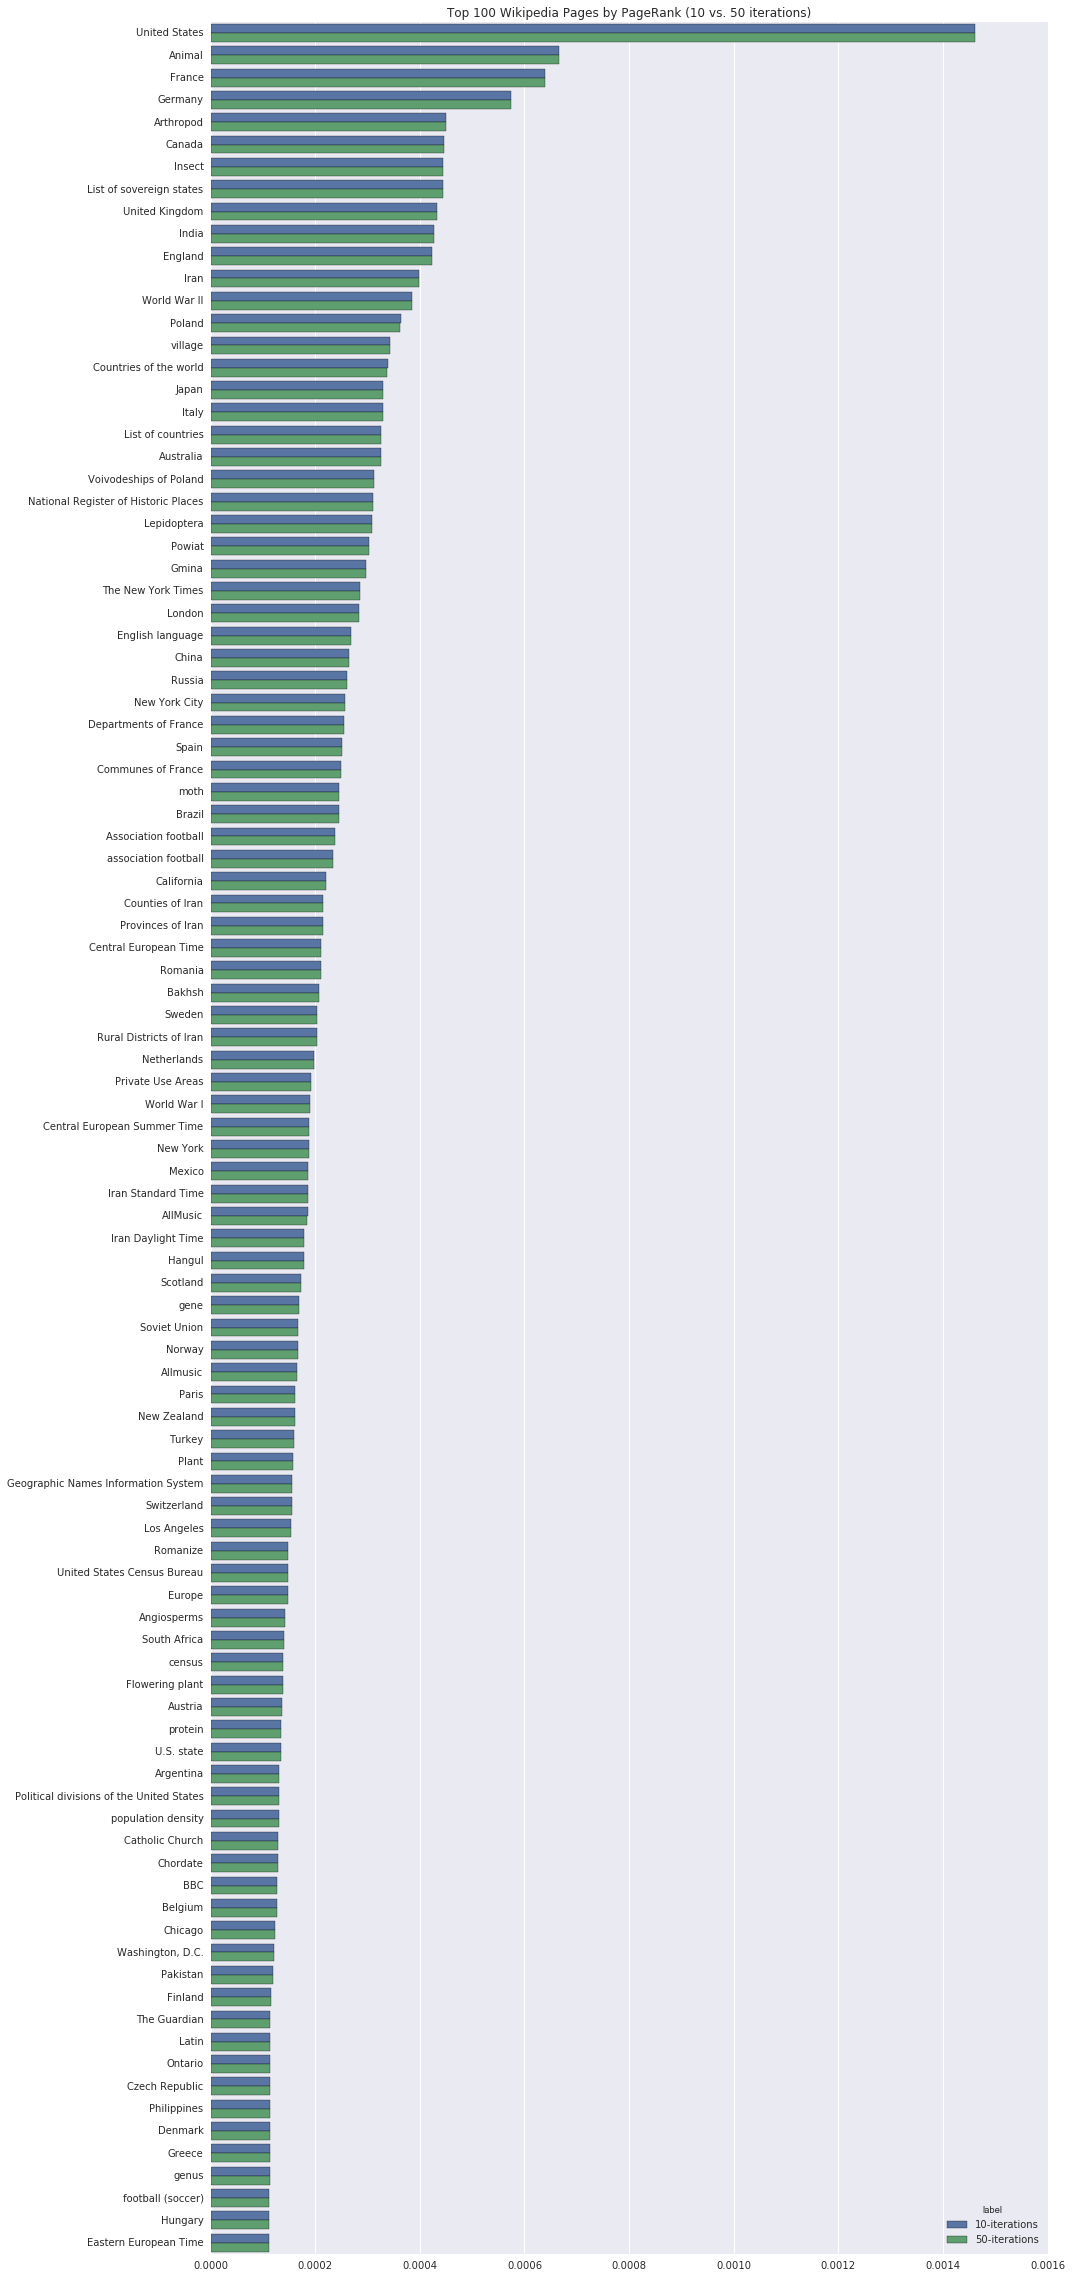

In [40]:
plot_comparison("emr_results_wiki_10iter.txt", 10, "emr_results_wiki_50iter.txt", 50)

### 13.2 Response

For our custom Spark implementation, between 10 and 50 iterations, there aren't significant changes in page rank values.

### HW 13.3: Spark GraphX versus your implementation of PageRank

Run the Spark  GraphX PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves.

Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

Put the runtime results of HW13.2 and HW13.3 in a tabular format (with rows corresponding to implemention and columns corresponding to experiment setup (10 iterations, 50 iterations)). Discuss the run times and explaing the differences. 

Plot the pagerank values for the top 100 pages resulting from the 50 iterations run (using GraphX). Then plot the pagerank values for the same 100 pages that resulted from the 50 iterations run of your homegrown pagerank implemnentation.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

### 13.3 EMR
The EMR parts are done in the Zeppelin notebook: [Zeppelin Notebook Link](<https://www.zeppelinhub.com/viewer/notebooks/aHR0cHM6Ly9yYXcuZ2l0aHVidXNlcmNvbnRlbnQuY29tL0tvbm5pYW1DaGFuL21hY2hpbmUtbGVhcm5pbmctYXQtc2NhbGUvbWFzdGVyL1dlZWtfMTMvbm90ZS5qc29u>)  

### 13.3: Top 100 nodes 50 iterations (GraphX implementation)

In [54]:
print get_df("emr_results_wiki_graphx_50iter_joined.txt", None)[['page', 'rank']]

                                        page        rank
0                              United States  0.00146156
1                                     Animal  0.00066602
2                                     France  0.00063968
3                                    Germany  0.00057477
4                                  Arthropod  0.00045012
5                                     Canada  0.00044667
6                                     Insect  0.00044463
7                   List of sovereign states  0.00044388
8                             United Kingdom  0.00043314
9                                      India  0.00042771
10                                   England  0.00042342
11                                      Iran  0.00039783
12                              World War II  0.00038549
13                                    Poland  0.00036267
14                                   village  0.00034359
15                    Countries of the world  0.00033805
16                             

### 13.3: Top 100 nodes 10 & 50 iterations (GraphX implementation)

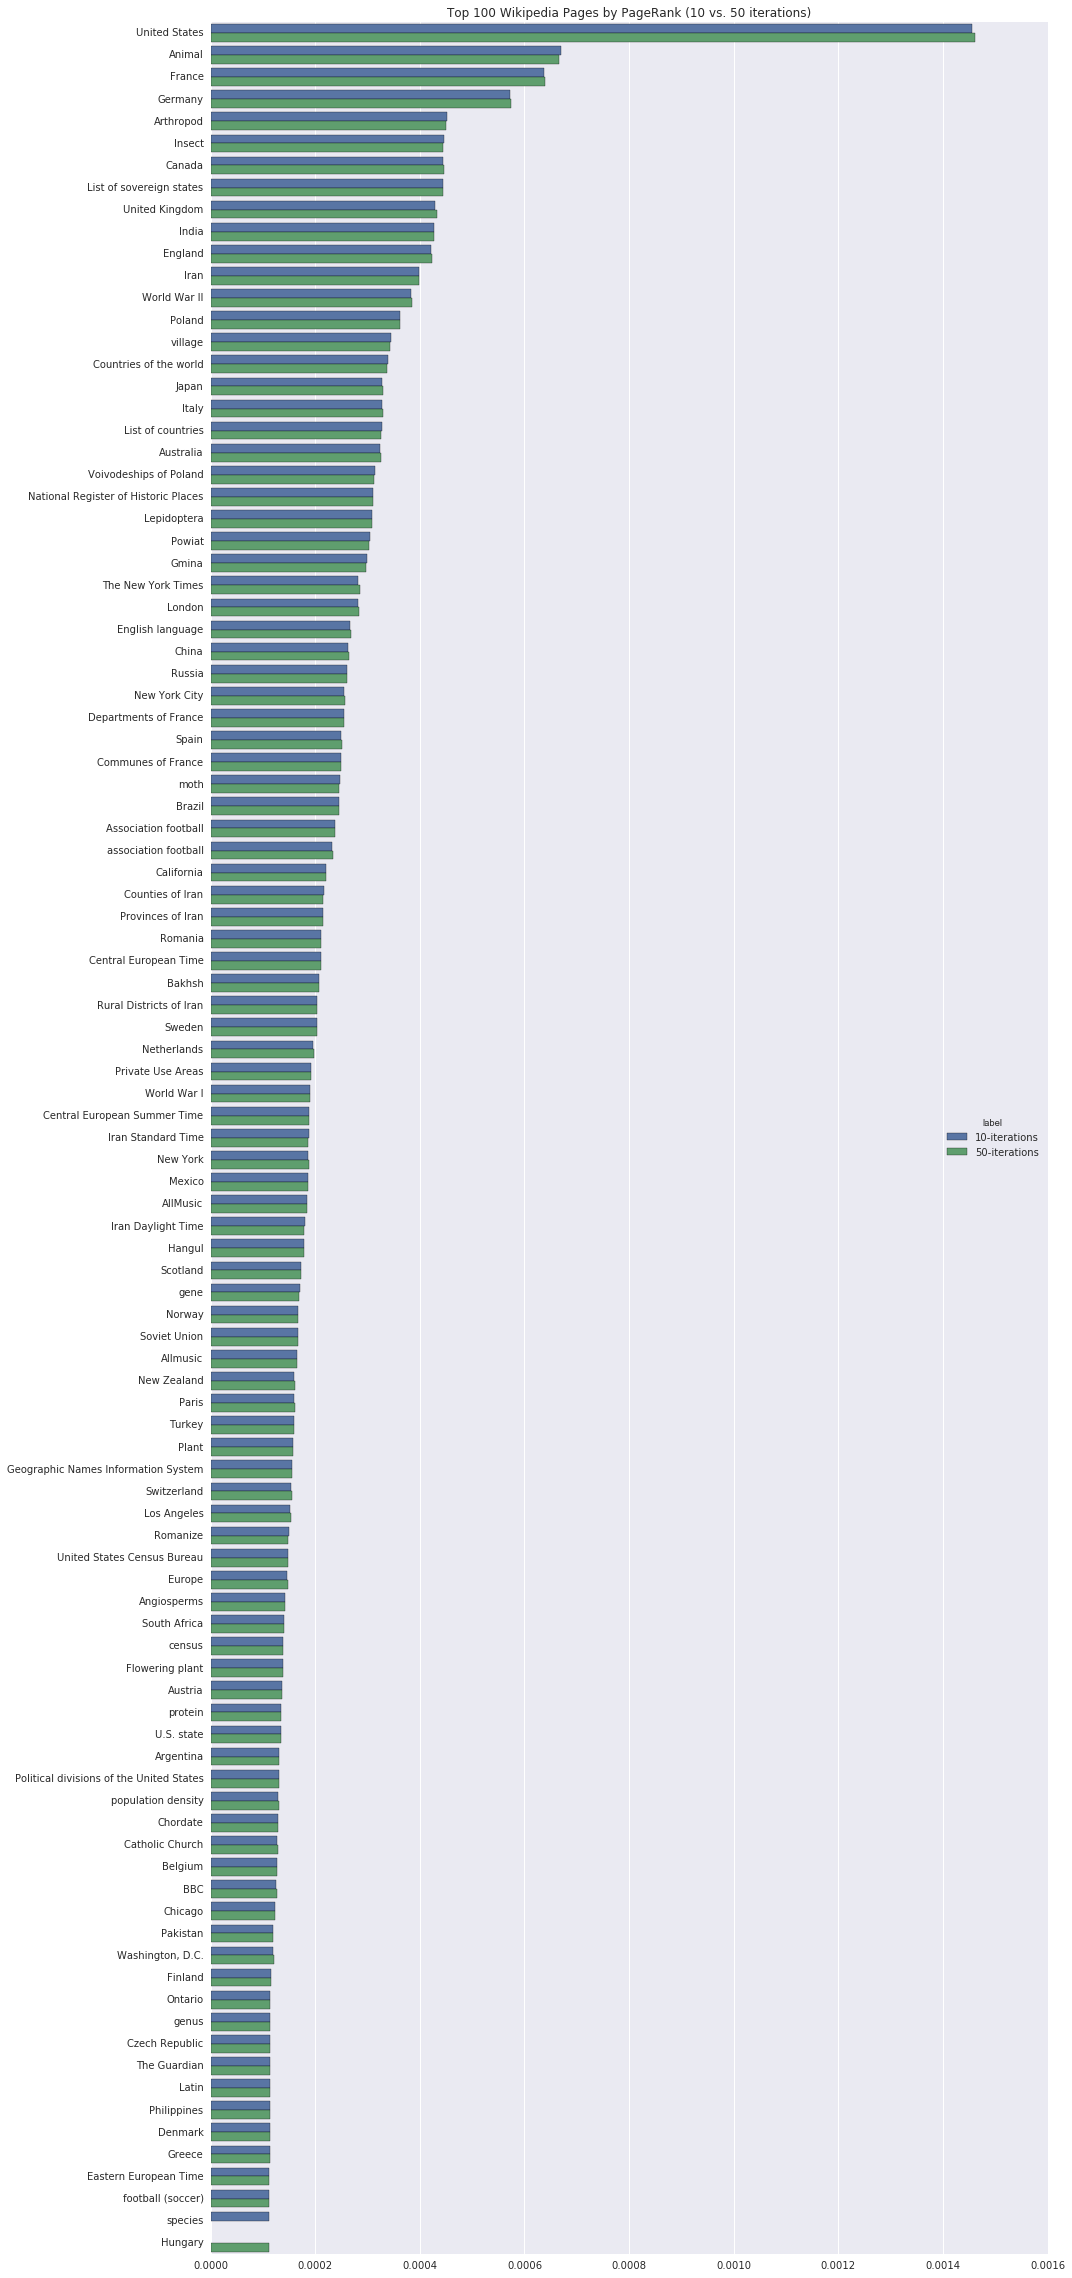

In [55]:
plot_comparison("emr_results_wiki_graphx_10iter_joined.txt", 10, "emr_results_wiki_graphx_50iter_joined.txt", 50)

### 13.3: Top 100 nodes 50 iterations (home-grown Spark v. GraphX)

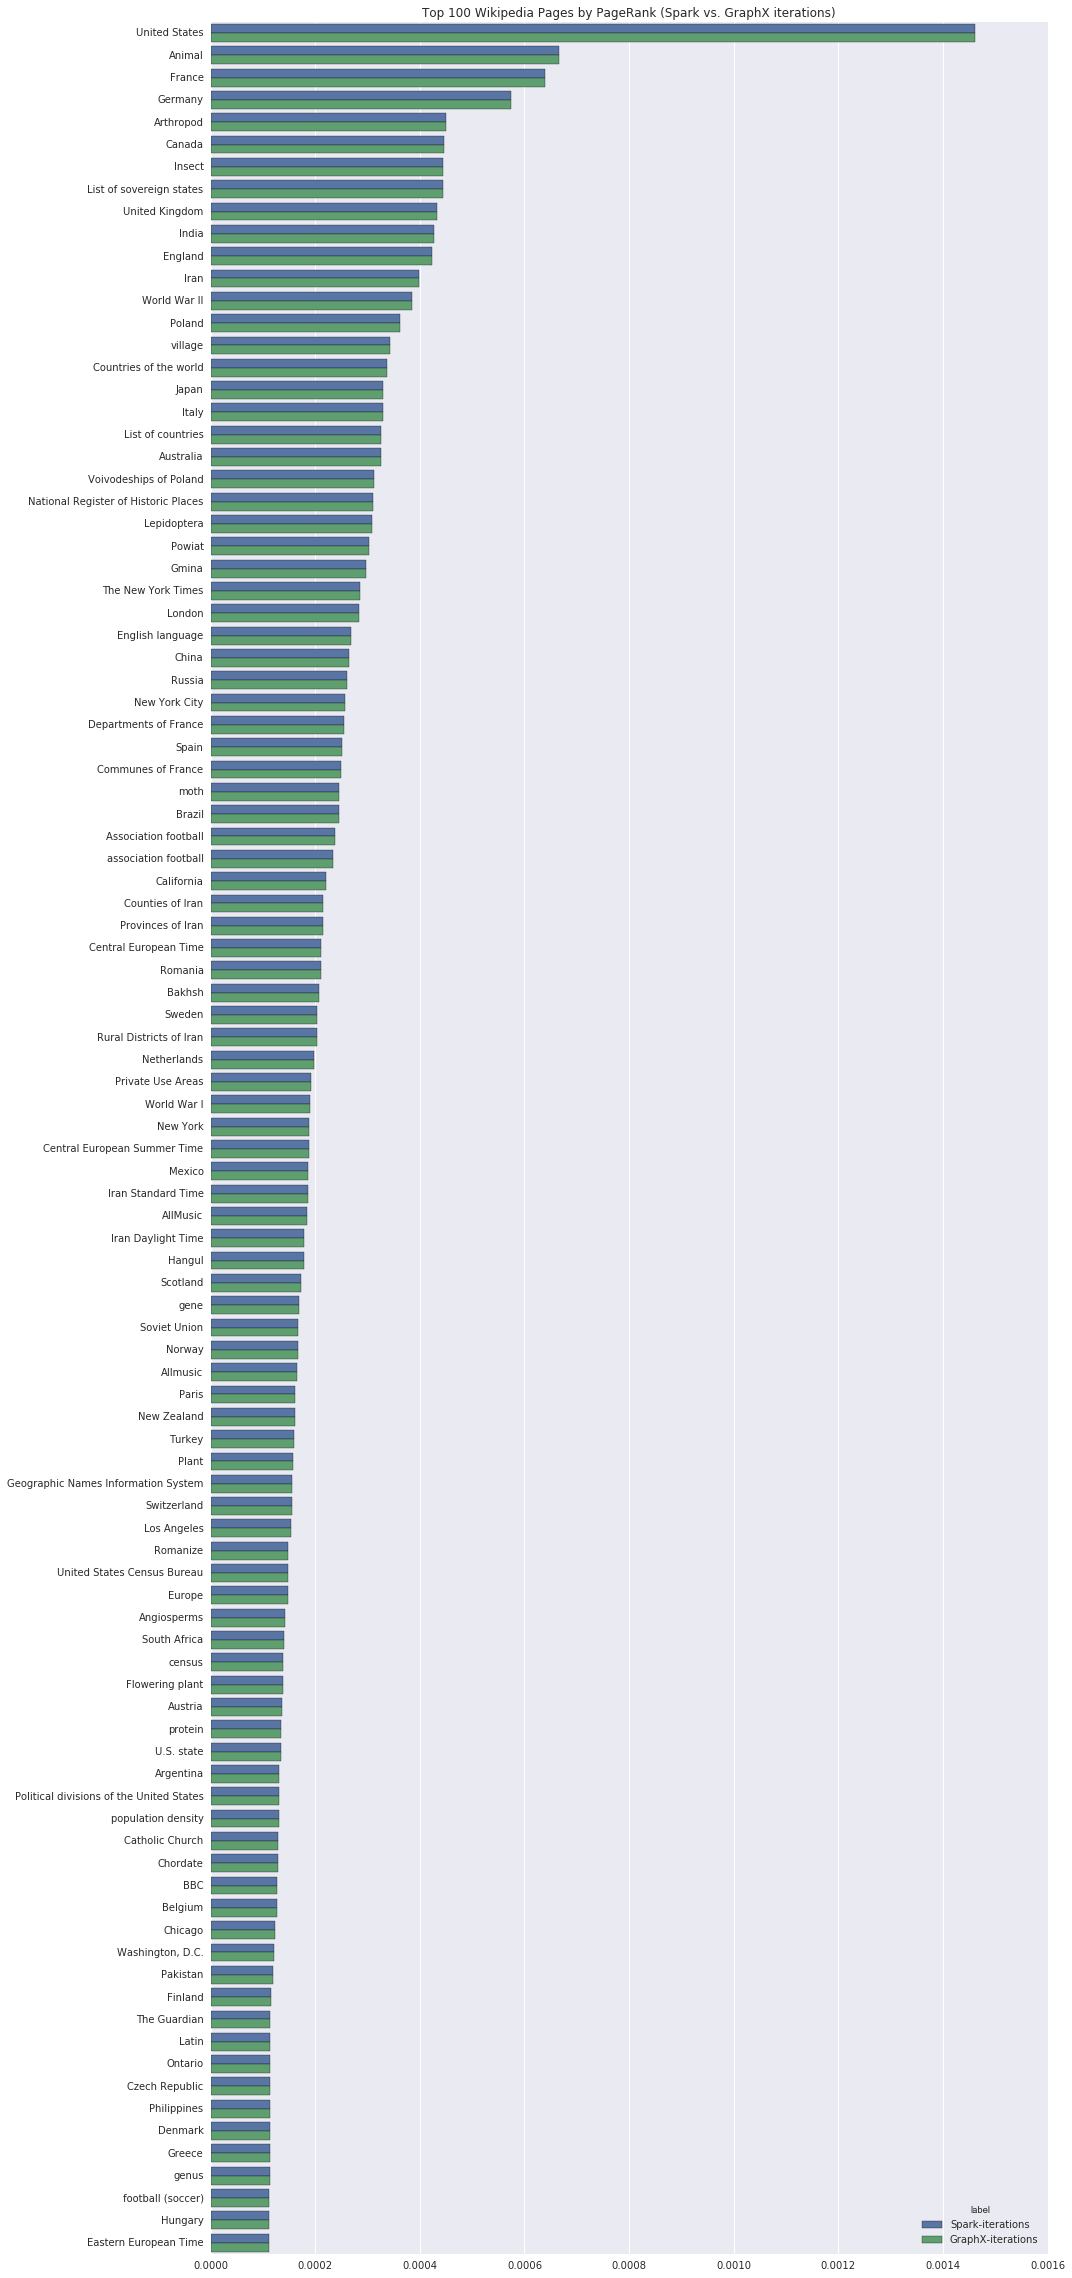

In [57]:
plot_comparison("emr_results_wiki_50iter.txt", 'Spark', "emr_results_wiki_graphx_50iter_joined.txt", 'GraphX')

### 13.3 Response
For GraphX 10 and 50 iterations, there seems to be larger pagerank changes, compared to the Spark custom implementation. The difference comes from the 10-iterations result of GraphX and Spark custom. It could be the case that the GraphX implementation has different initial conditions, leading to small differences in pageranks for 10 iterations. Both GraphX and Spark custom converge to identical pageranks after 50 iterations.  
  
#### AWS EMR Configuration
- 1 Master node (m4.large, 2 vCPU, 8GB ram)
- 6 Core nodes (r3.xlarge, 4 vCPU, 30GB ram)

| Implementation| Iterations    | Runtime (mins)|
| ------------- |---------------|---------------|
| Spark custom  | 10            | 27            |
| Spark custom  | 50            | 112           |
| GraphX        | 10            | 5             |
| GraphX        | 50            | 18            |
  
While our homegrown Spark implementation finished 50 iterations in under 2 hours (substantially faster than Hadoop), the GraphX implmentation is at least 5x faster. The GraphX job finished in 18 minutes. In the Spark version, we have to keep joining the adjacency lists with updated ranks, a massive operation. In GraphX, the graph is represented as a series of Vertex and Edges RDD's. The local structure of the graph is exploited to reduce communication and computation.